
The data required to run this notebook (inlcluding the notebook itself) is shared on Moodle. The data is saved in a pickle format with the file name "clean_data_v2.pickle". You need to save this file on your PC,and then load it using an approprite file path, see the loading data section below.

You only need to fill out the parts that you are asked to do so. You can find these parts by looking
for word "Exercise" using Ctrl+F.

You may need to install certain packages in order for the code to run. All the necessary packages are below. 

Note that this notebook contains a lot of other information which is just for informative purposes, but in order to do the exercises you will need to understand the whole document (or at least most of it). You can try to explore this file.

The approximated number of lines requierd for coding for each exercise is provided to you. You should not feel guilty if your lines of codes are longer.

Marks for each exercise are shown in brakcets; note that these marks are provisional and they might be changed.


In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


In [2]:
#Define a default random seed and an output file

default_seed = 1
output_file = "output_sample"


In [3]:
#Loading the data from a compressed file
#Note that you could use a different path
data, discrete_features, continuous_features = pickle.load( 
    open( "clean_data_v2.pickle", "rb" ) )


In [4]:
#Showing discrete_features
discrete_features

['home_ownership',
 'grade',
 'emp_length',
 'purpose',
 'verification_status',
 'term']

In [5]:
#Let us see how data looks like
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,...,5475.14000,2015-12-01,0.0,10.973531,36,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,...,20452.09912,2018-03-01,0.0,37.947391,36,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,...,9792.56000,2015-11-01,0.0,9.987885,36,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,...,16592.91130,2018-01-01,0.0,36.008953,36,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,...,15122.07997,2018-10-01,0.0,44.978336,60,0.102442,0.136655,0.113866,0.131897,0.164518


Different types of interest rate definitions are defined here. Five types of returns are defiend: these are called return_1, return_2 return_3a, return_3b, return_3c; see the following blocks.

In [6]:
#Return Number 1
data['return_1'] = ( (data.total_pymnt - data.funded_amnt) 
                                            / data.funded_amnt ) * (12 / data['term_num'])


#Return Number 2
# Assuming that if a loan gives a positive return, we can immediately find a similar loan to invest in; if the loan 
# takes a loss, we use modify the return based on the return_1


data['return_2'] = ( (data.total_pymnt - data.funded_amnt)
                                            / data.funded_amnt ) * (12 / data['loan_length'])
data.loc[data.return_2 < 0,'return_2'] = data.return_1[data.return_2 < 0]


# Exercise 1 --- 6 or 7 lines of coding - [5/15]

In [7]:
#Return Number 3: Write down a method that calculate returns under the following assumptions:
#1) The coupons (repaymetns of the loans) are immediately reinvested with the initial prime rate i effective 
#   per month.
#2) The total paid back amount (indicated by feature "total_pymnt"), is paid back at level (equal) monthly 
#   payments during the duration of the loan (indicated by the feature "loan_length"). Note that in this dataset 
#   the total payment includes the recovery (indicated by the feature "recoveries").
#3) The monthly payments are re-invested at the prime rate i until T months from the start.
#4) In your code, briefly  point out (through wirting short comments) where each one of the above assumptions is used.
#5) Your function takes the three inputs, the data, T, and i; and it must return the annualized return.
#
#
#----------------------------------
#Write your code bellow

#--------------------------------------

$$S=\dfrac{x_{2}}{m}\dfrac{\left( 1+j\right) ^{m}-1}{j}\left( 1+j\right) ^{t-m}$$

$$ret_3 = \dfrac{S-x_{1}}{x_{1}}\cdot \dfrac{12}{t}$$

In [8]:
def ret_method_3(data, T, i):
    # Sort the index since they are not perfectly sorted
    data = data.reset_index()
    # Create an empty list to store ret_3 for each loan record
    repay_list = []
    for j in range(len(data)):
        # Monthly return over the actual loan period
        monthly_repayment = data.total_pymnt[j]/data.loan_length[j]
        # Sum of the monthly repayment return at the end of actual loan lifetime
        # given an interest rate i
        total_repayment_loan_length = monthly_repayment *(((1+i)**data.loan_length[j] -1)/i)
        # At the end of the actual loan lifetime we reinvest the total repayment until the
        # end of the nominal loan lifetime
        total_repayment = total_repayment_loan_length * (1+i)**(T-data.loan_length[j])
        # Calcualte the annualised return the loan
        ret_3 = (total_repayment - data.funded_amnt[j])/data.funded_amnt[j]*(12/T)
        # Append each loan's return to the list
        repay_list.append(ret_3)
        
    return repay_list
        

In [9]:
#Calculating three different types of returns based on the ret_method_3
data['return_3a'] = ret_method_3(data, 5*12, 0.001)
data['return_3b'] = ret_method_3(data, 5*12, 0.0025)
data['return_3c'] = ret_method_3(data, 5*12, 0.005)


In [10]:
# Inspect the data
data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,return_1,return_2,return_3a,return_3b,return_3c
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,...,0.031676,0.103917,0.031155,0.050634,0.086751,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,...,0.067688,0.064215,0.050574,0.066334,0.094950,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,...,0.029354,0.105803,0.029798,0.049345,0.085622,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,...,0.061736,0.061721,0.047093,0.063007,0.091937,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,...,0.102442,0.136655,0.113866,0.131897,0.164518,0.102442,0.136655,0.113866,0.131897,0.164518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048430,139391862,25000.0,25000.0,36 months,19.92,928.08,D,10+ years,RENT,54173.0,...,0.030100,0.182219,0.030735,0.051117,0.089089,0.030100,0.182219,0.030735,0.051117,0.089089
1048442,139388430,15000.0,15000.0,60 months,14.47,352.69,C,10+ years,MORTGAGE,115000.0,...,0.011731,0.140018,0.024141,0.044108,0.081340,0.011731,0.140018,0.024141,0.044108,0.081340
1048471,139248973,10000.0,10000.0,36 months,20.89,376.19,D,5 years,RENT,75000.0,...,0.028473,0.203910,0.029807,0.050279,0.088453,0.028473,0.203910,0.029807,0.050279,0.088453
1048488,138986745,12800.0,12800.0,36 months,24.37,504.68,E,6 years,RENT,60000.0,...,0.006092,0.222524,0.016028,0.035984,0.073344,0.006092,0.222524,0.016028,0.035984,0.073344


In [11]:
#putting all return names in one list
return_cols=["return_1","return_2","return_3a","return_3b","return_3c"]

In [12]:
#Calculate mean, standard deviation of returns; for instance:
print(data["return_2"].mean(), data["return_2"].std())


0.04580137736406662 0.1076282631505881


In [13]:
#Calculate correlation between continuous features
data[continuous_features].corr()

,loan_amnt,funded_amnt,installment,annual_inc,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,int_rate,revol_util
loan_amnt,1.000000,1.000000,0.952850,0.310914,0.020821,0.318580,-0.008796,0.182188,-0.070506,0.113521,0.113521,0.123118,0.112286
funded_amnt,1.000000,1.000000,0.952850,0.310914,0.020821,0.318580,-0.008796,0.182188,-0.070506,0.113521,0.113521,0.123118,0.112286
installment,0.952850,0.952850,1.000000,0.300108,0.024823,0.305464,0.000127,0.169690,-0.058493,0.067724,0.067725,0.139536,0.126779
annual_inc,0.310914,0.310914,0.300108,1.000000,-0.144491,0.281997,0.035928,0.130390,-0.004934,0.074356,0.074356,-0.086107,0.037410
dti,0.020821,0.020821,0.024823,-0.144491,1.000000,0.102385,-0.012619,0.213876,-0.037522,-0.050331,-0.050328,0.166301,0.141012
revol_bal,0.318580,0.318580,0.305464,0.281997,0.102385,1.000000,-0.029442,0.222358,-0.096787,0.030348,0.030350,-0.044143,0.242095
delinq_2yrs,-0.008796,-0.008796,0.000127,0.035928,-0.012619,-0.029442,1.000000,0.046739,-0.021757,-0.171641,-0.171643,0.042665,-0.008660
open_acc,0.182188,0.182188,0.169690,0.130390,0.213876,0.222358,0.046739,1.000000,-0.022263,0.031051,0.031053,-0.005516,-0.143820
pub_rec,-0.070506,-0.070506,-0.058493,-0.004934,-0.037522,-0.096787,-0.021757,-0.022263,1.000000,-0.197870,-0.197872,0.058018,-0.069936
fico_range_high,0.113521,0.113521,0.067724,0.074356,-0.050331,0.030348,-0.171641,0.031051,-0.197870,1.000000,1.000000,-0.375064,-0.448503


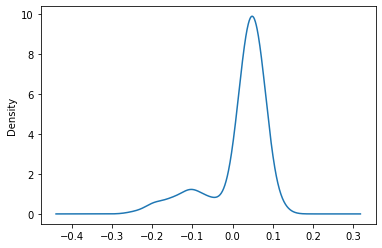

In [14]:
#Empirical densities
data["return_1"].iloc[0:500].plot.kde()
pass

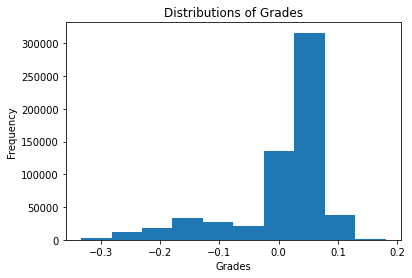

In [15]:
# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(data['return_1'])
# set title and labels
ax.set_title('Distributions of Grades')
ax.set_xlabel('Grades')
ax.set_ylabel('Frequency')
pass

<AxesSubplot:ylabel='Frequency'>

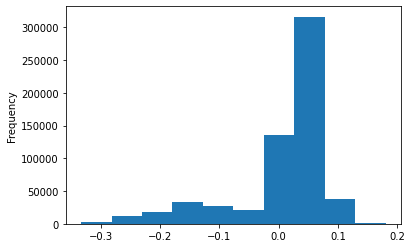

In [16]:
data['return_1'].plot.hist()


array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

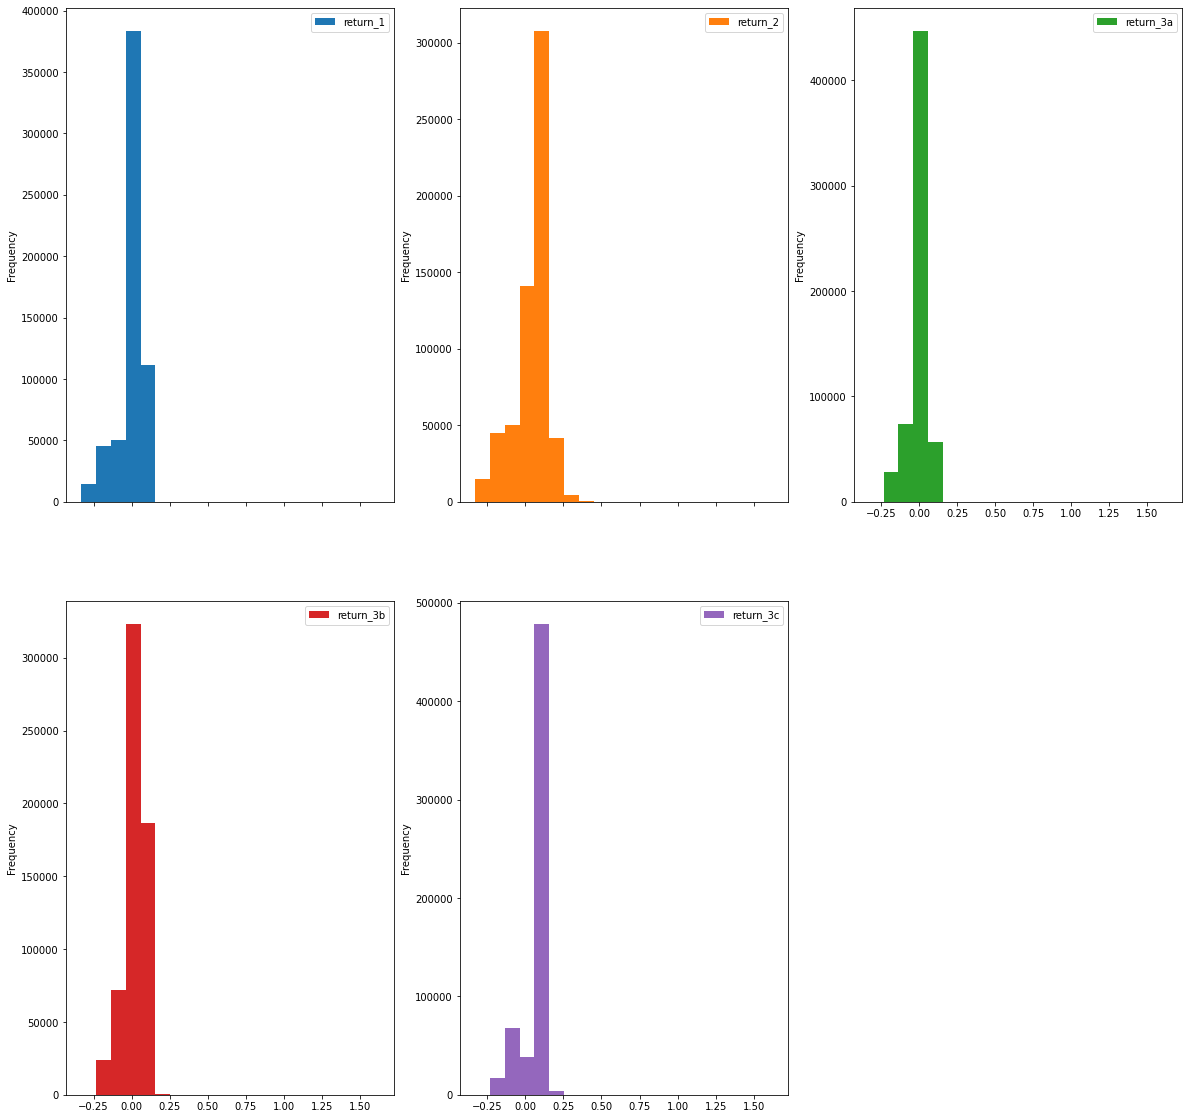

In [17]:
data[return_cols].plot.hist(subplots=True, layout=(2,3), figsize=(20, 20), bins=20)


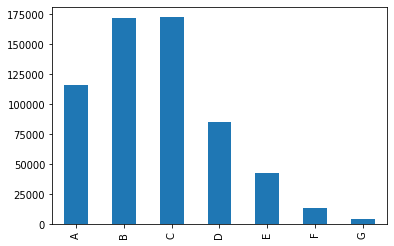

In [18]:
#bar charts: an example
data['grade'].value_counts().sort_index().plot.bar()
pass

In [19]:
#Seaborn is a Python data visualization library based on Matplotlib. It provides a high-level interface for
#creating attractive graphs. Seaborn has a lot to offer. You can create graphs in one line that would 
#take you multiple tens of lines in Matplotlib. Its standard designs are awesome and it 
#also has a nice interface for working with pandas dataframes.

import seaborn as sns 
%matplotlib inline

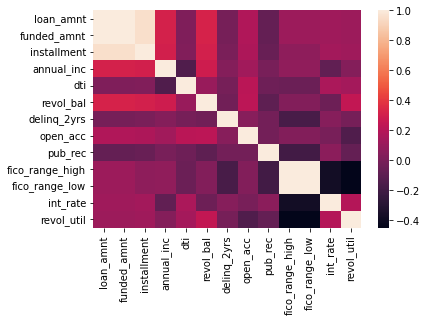

In [20]:
#A Heatmap is a graphical representation of data where the individual values contained in a matrix are 
#represented as colors. Heatmaps are perfect for exploring the correlation of features in a dataset.
#To get the correlation of the features inside a dataset we can call <dataset>.corr(), which is a 
#Pandas dataframe method. This will give us the correlation matrix.

sns.heatmap(data[continuous_features].corr(), annot=False)
pass

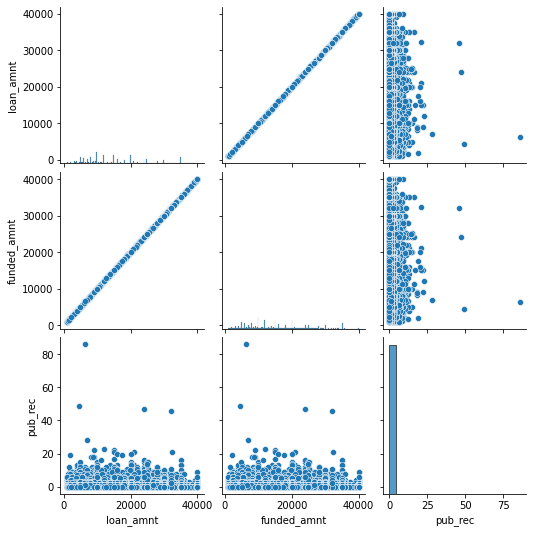

In [21]:
sns.pairplot(data[["loan_amnt","funded_amnt","pub_rec"]])


<AxesSubplot:xlabel='term', ylabel='count'>

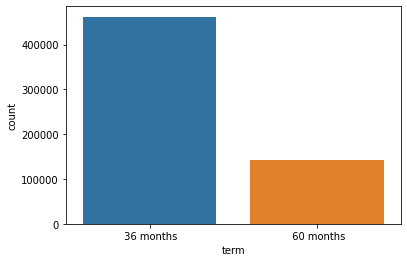

In [22]:
sns.countplot(x='term',data=data)

<AxesSubplot:xlabel='grade', ylabel='count'>

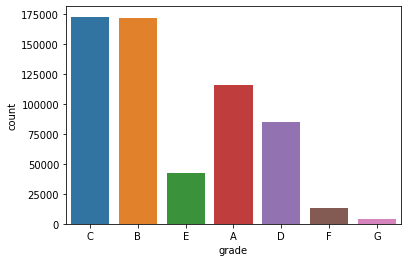

In [23]:
sns.countplot(x='grade',data=data)

<AxesSubplot:xlabel='grade', ylabel='loan_amnt'>

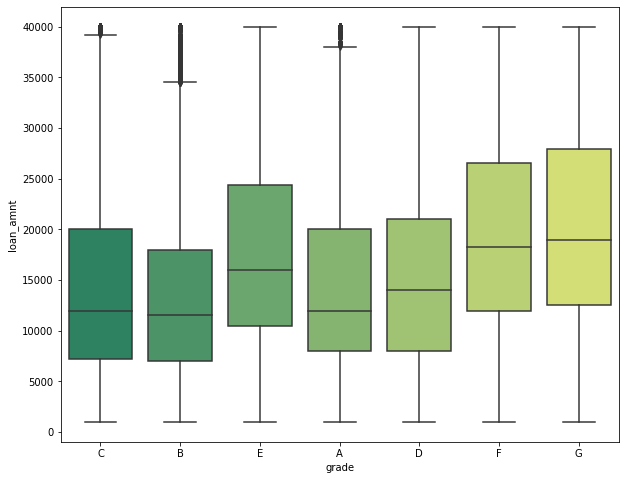

In [24]:
plt.figure(figsize=(10,8))
sns.boxplot(x='grade',y='loan_amnt',data=data,palette="summer")

<AxesSubplot:xlabel='funded_amnt'>

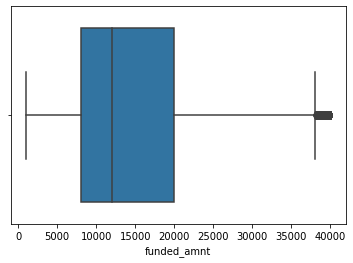

In [25]:
i=1
sns.boxplot(x=data[continuous_features[i]])


In [26]:
data.loan_status.value_counts()


Fully Paid     477373
Charged Off    127980
Default            21
Name: loan_status, dtype: int64

# Exercise 2 --- 9 or 10 lines of coding - [5/15]


In [27]:
#For this exercise, first, find the percentage of loans by grade in the dataset. 
#Second, for each grade category, find the average of int_rate and return_1 of the loans. 
#Third, find the precentage of loans defaulted in each grade category. Show your result in a table like
#below. Store the result in a Panda dataframe and call it combined.
#
#
#----------------------------------
#Write your code bellow

#----------------------------------
num_group = data.groupby('grade').agg({'grade': lambda x: 100*len(x)/len(data),                
                                       'int_rate': 'mean', 
                                       'return_1': lambda x: 100*np.mean(x),
                                        })
cat_group = data.groupby('grade', as_index=False)['loan_status'].value_counts(normalize=True)
cat_group = cat_group[(cat_group.loan_status!='Fully Paid') ].groupby('grade').\
            agg({a'proportion': lambda x: 100*np.sum(x)})
cat_group = cat_group.rename(columns={'proportion':'default'})

combined = pd.concat([num_group, cat_group], axis=1)
combined.index.name = None

combined

,grade,int_rate,return_1,default
A,19.184339,6.877237,1.649014,6.123802
B,28.356520,10.150223,1.324803,14.233120
C,28.562674,13.576124,0.427756,23.923868
D,14.029674,17.389625,-0.456187,33.344323
E,6.990885,20.601166,-1.382236,42.090215
F,2.179810,24.977874,-2.378748,50.545620
G,0.696099,28.598315,-3.714312,54.247746


In [28]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [29]:
data['outcome'] = data.loan_status!='Fully Paid'

In [30]:
# Create a matrix of features and outcomes, convert categorical features using dummies. 
x_continuous = data[continuous_features]
x_discrete = pd.get_dummies(data["grade"], dummy_na = True, prefix_sep = "::", drop_first = False)
y = data.outcome.values

#store return values in y_return
y_return1 = data.return_1
y_return2 = data.return_2
y_return3a = data.return_3a
y_return3b = data.return_3b
y_return3c = data.return_3c

In [31]:
# For simplicity, we only consider the first seven discrete features as the space of
# features and the y_return1 as the resposne variable. 
#Split dataset into training set and test set for y_return1 for 60% training, 20% cross validation, and 20% testing
x_train, x_test, y_return_train, y_return_test = train_test_split(x_discrete.iloc[:,0:7], y_return1, test_size=0.4,
                                                                  random_state=default_seed) 
x_test, x_val, y_return_test, y_return_val = train_test_split(x_test, y_return_test, test_size=0.5,
                                                                  random_state=default_seed) 


In [32]:
#Performing a linear regression fitting for the return_1 with no regularization

grade_only_linear = LinearRegression()
grade_only_linear.fit(x_train, y_return_train)
parameters_linear = grade_only_linear.coef_

y_pred_linear = grade_only_linear.predict(x_test)

In [33]:
#Searching for the optimal regularization parameter using the cross validation dataset
#Using the cross validation set, we obtain the optimal alpha that minimizes the mean-square error
#of predicted returns on the cross validation set. 

error = []
error_val = []
alphas = range(0, 1000, 5)
for a in alphas:
    ridge_regular = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge_regular.fit(x_train, y_return_train)
    y_pred = ridge_regular.predict(x_train)
    y_pred_val = ridge_regular.predict(x_val)
   
    error.append(mean_squared_error(y_return_train, y_pred))
    error_val.append(mean_squared_error(y_pred_val, y_return_val))

min_index = error_val.index(min(error_val))
alpha_star = alphas[min_index]
print(alpha_star)
#--------------------------------------

565


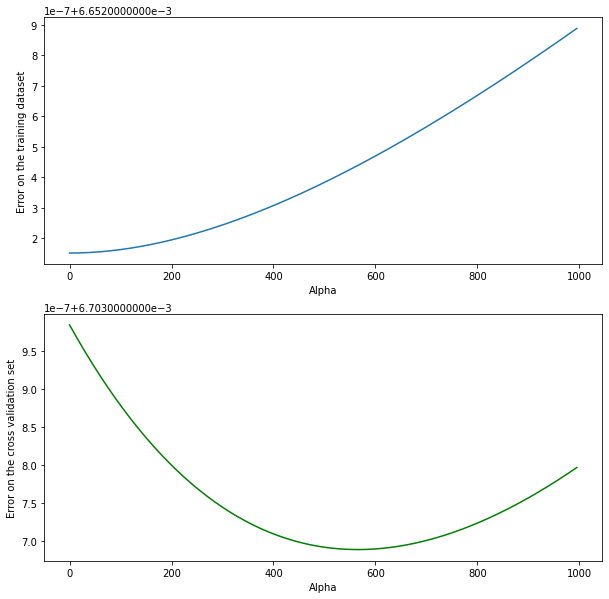

In [34]:
#The result of the last block could be shown graphically as follows:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(alphas,error)
plt.xlabel('Alpha')
plt.ylabel('Error on the training dataset')

plt.subplot(2, 1, 2)
plt.plot(alphas,error_val,color='green')
plt.xlabel('Alpha')
plt.ylabel('Error on the cross validation set')
plt.show()
#Look at the following figures; what do you observe?

In [35]:
#Now, we calcualte the mean-square error on the test dataset using the optimal alpha that we already obtained
#and the defaulted one used by the Ridge regression of the lienar model; see if the validation procedure has been
#effective


ridge_regular_optimal = linear_model.Ridge(alpha=alpha_star, fit_intercept=True)
ridge_regular = linear_model.Ridge(alpha=1, fit_intercept=True)

ridge_regular_optimal.fit(x_train,y_return_train)
y_pred = ridge_regular.fit(x_train, y_return_train).predict(x_test)
y_pred_optimal = ridge_regular_optimal.predict(x_test)

print(mean_squared_error(y_pred, y_return_test))
print(mean_squared_error(y_pred_optimal, y_return_test))



0.006653111637479146
0.0066534301197469815


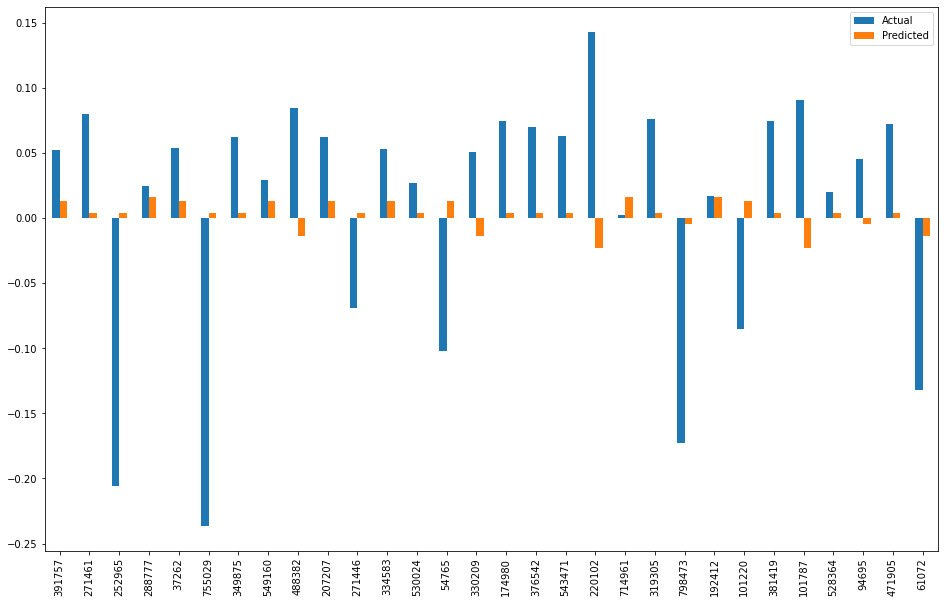

In [36]:
#Let us compare the predicted and actual predictoins of the ridge model.
y_pred_train = ridge_regular_optimal.predict(x_train)
df = pd.DataFrame({'Actual': y_return_train, 'Predicted': y_pred_train})
df1 = df.head(30)

df1.plot(kind='bar', figsize=(16,10))
plt.show()

# Exercise 3 - Max 300 words (excluding the pseudo code) (5/15)


You already know two approaches to measure the importance of features: linear regression and tree type models such as random forest. Explain how the concept of regularization in models such as ridge regression can be used to come up with another notion
of importance. 

Your explanations must include a pseudocode implementing an algorithm that shows how the importance of all the features are calculated and returned.

Your explanations should be right to the point, concise, clear, and free from spelling error and grammatically correct.

Write your answer below:



$$ L =
\frac{1}{m}\left[\sum_{i=1}^{m}\left(y^{(i)}-h\left(x^{(i)}\right)\right)^{2}+\alpha \sum_{j=1}^{n} w_{j}^{2}\right]
$$

The equation above is the loss function of ridge regression. Suppose we have a sample containing m examples and n features. The objective is to find the weights that minimise the loss function.

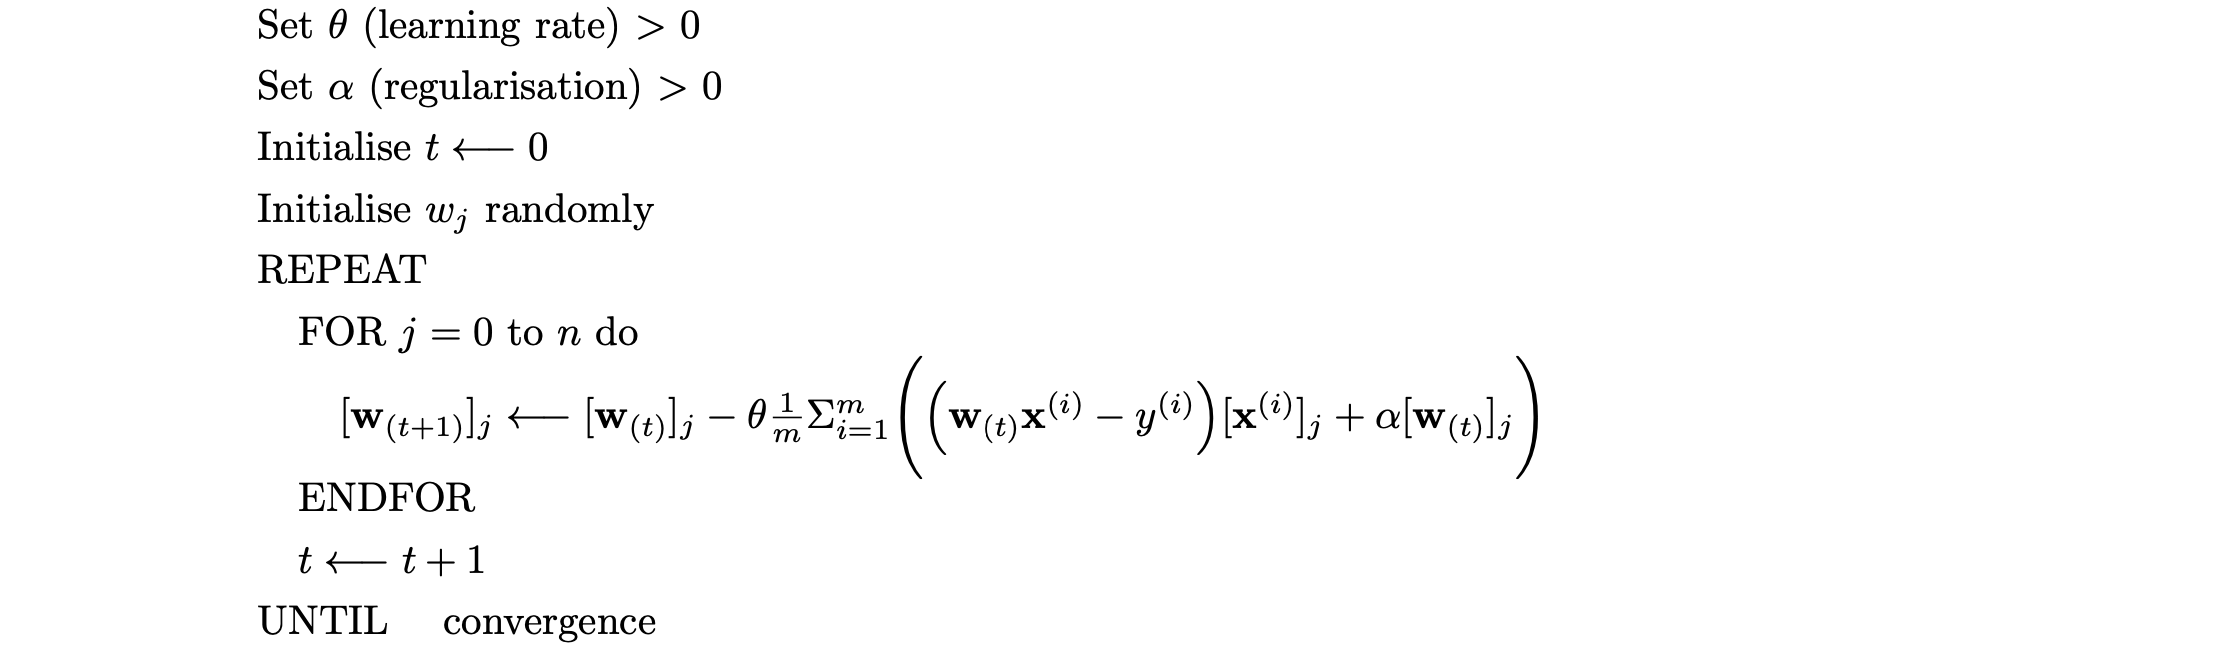

Ridge regression is built upon the linear regression by adding an additional regularisation term on weights. The pseudocode uses gradient descent to minimise the loss function until convergence. If the regularisation parameter is set to zero, the process is equivalent to finding weights for linear regression. If we impose a large alpha, the algorithm will seek to reduce weights in order to achieve the goal. Different features have different rates of shrinkage. For some "unimportant" features, their weights will be close to zero at a given alpha, while others will still be no-zero. In this sense, ridge regression performs feature selection as the algorithm automatically shrink "unimportant" features' weights to almost zero. When the regularisation parameter is set to a large number, all weights could be shrunk to almost zero. Notably, the bias increases with as the regularisation parameter increases, and variance increases as it decreases. 